In [2]:
import sqlite3 as sql
import pandas as pd
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
import dateutil
import datetime
import sklearn
import preprocessing

In [3]:
%load_ext autoreload
%autoreload 2

In [32]:
S_data_2019_04_04 = preprocessing.Preprocessing('S_data_2019_04_04','/Users/cm/20190403/','home-assistant_v2.db')

In [33]:
rooms = ['schlafzimmer','bad','kuche','wohnzimmer']

In [34]:
S_data_2019_04_04.load_data(rooms=rooms)

#### extract weather data

In [35]:
S_data_2019_04_04.extract_weather_data()

In [39]:
S_data_2019_04_04.weather_data['weather_temperature']

,state,last_updated
0,9.9,2019-03-21 21:31:00.076497
1,9.7,2019-03-21 22:31:00.078014
2,9.1,2019-03-21 23:31:00.077255
3,8.5,2019-03-22 00:31:00.074930
4,7.7,2019-03-22 01:31:00.072222
5,6.7,2019-03-22 02:31:00.073965
6,6.3,2019-03-22 03:31:00.059154
7,5.3,2019-03-22 04:31:00.069812
8,7.2,2019-03-22 06:31:00.068071
9,9.0,2019-03-22 07:31:00.070494


In [36]:
states = pd.read_sql_query('select state,last_updated, entity_id from states where (domain like "sensor" and entity_id like "%weather%")', S_data_2019_04_04.conn)

In [37]:
weather_opts =['weather_temperature','precipitation','wind_speed','pressure','wind_direction','humidity','fog','cloudiness','low_clouds','medium_clouds','high_clouds','dewpoint_temperature']

In [11]:
weatherdata={}
for opt in weather_opts:
    df = states[states['entity_id'].str.contains(opt)][['state','last_updated']]
    df = df[df.state !='unknown']
    df['state'] = df['state'].astype('float')
    df = df.reset_index(drop=True)
    weatherdata[opt] = df

In [12]:
def add_wp(time_steps,set_temps,time_row):
    for index, ti in enumerate(time_steps):
        #print(str(index), str(ti))
        if time_row < ti:
            #print(str(time_row) + ' ' +str(ti)+' ' + str(index) + ' ' + str(set_temps[index-1]))
            return set_temps[index]

In [13]:
frame = S_data_2019_04_04.get('train_raw_climatewohnzimmer').reindex()
frame.loc[:,'last_updated'] = frame.loc[:,'last_updated'].map(lambda x: dateutil.parser.parse(x))

In [14]:
weather_feature = {}
feat = []

for opt in weather_opts:
    for row in frame.index:
        feat.append(add_wp(weatherdata[opt]['last_updated'], weatherdata[opt]['state'], frame.loc[row,'last_updated']))
    weather_feature[opt]=feat
    frame[opt]=feat
    feat=[]

In [15]:
frame = frame.dropna(thresh=10)
frame = frame.dropna(axis=1)

In [16]:
#categorical = pd.get_dummies(frame[['state']])
#frame = pd.concat([frame, categorical], axis=1, sort=False)

In [17]:
frame['day'] = frame['last_updated'].dt.day
frame['month'] = frame['last_updated'].dt.month
frame['year'] = frame['last_updated'].dt.year
frame['time'] = frame['last_updated'].dt.time
frame['time'] = frame['time'].map(lambda x:x.hour+x.minute/60.0)

In [18]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368 entries, 0 to 367
Data columns (total 20 columns):
entity_id               368 non-null object
state                   368 non-null object
attributes              368 non-null object
last_updated            368 non-null datetime64[ns]
current_temp            368 non-null float64
set_temp                368 non-null float64
weather_temperature     368 non-null float64
wind_speed              368 non-null float64
pressure                368 non-null float64
wind_direction          368 non-null float64
humidity                368 non-null float64
cloudiness              368 non-null float64
low_clouds              368 non-null float64
medium_clouds           368 non-null float64
high_clouds             368 non-null float64
dewpoint_temperature    368 non-null float64
day                     368 non-null int64
month                   368 non-null int64
year                    368 non-null int64
time                    368 non-null float

In [19]:
X_ = frame.drop(columns=['entity_id','attributes','state','current_temp','last_updated'])


In [22]:
X_

,set_temp,weather_temperature,wind_speed,pressure,wind_direction,humidity,cloudiness,low_clouds,medium_clouds,high_clouds,dewpoint_temperature,day,month,year,time
0,16.5,9.9,3.6,1025.9,182.3,90.5,32.0,1.6,0.8,32.0,8.5,21,3,2019,20.966667
1,16.5,9.9,3.6,1025.9,182.3,90.5,32.0,1.6,0.8,32.0,8.5,21,3,2019,21.050000
2,16.5,9.9,3.6,1025.9,182.3,90.5,32.0,1.6,0.8,32.0,8.5,21,3,2019,21.216667
3,16.5,9.9,3.6,1025.9,182.3,90.5,32.0,1.6,0.8,32.0,8.5,21,3,2019,21.300000
4,16.5,9.9,3.6,1025.9,182.3,90.5,32.0,1.6,0.8,32.0,8.5,21,3,2019,21.383333
5,16.5,9.7,3.5,1025.7,199.1,91.9,32.0,1.6,0.8,32.0,8.4,21,3,2019,22.150000
6,16.5,9.7,3.5,1025.7,199.1,91.9,32.0,1.6,0.8,32.0,8.4,21,3,2019,22.233333
7,16.5,9.7,3.5,1025.7,199.1,91.9,32.0,1.6,0.8,32.0,8.4,21,3,2019,22.483333
8,16.5,9.1,3.3,1025.4,218.2,92.1,61.7,1.6,0.8,61.7,7.9,21,3,2019,22.566667
9,16.5,7.7,2.4,1025.1,265.7,94.4,12.5,1.6,0.8,12.5,6.8,22,3,2019,0.600000


In [479]:
y_ = frame['current_temp']

In [480]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [481]:
X_train, X_val, y_train, y_val = train_test_split(X_, y_,  test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,  test_size=0.2, random_state=42)

In [482]:
min_max_scaler.fit(X_train)

/Users/cm/anaconda3/envs/week_program/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [483]:
X_train = min_max_scaler.transform(X_train)
X_val= min_max_scaler.transform(X_val)

In [484]:
X_train.shape

(235, 15)

In [485]:
from sklearn.neighbors import KNeighborsRegressor

In [486]:
train_errors = []
test_errors = []
train_errors_val = []

for k in range(1,100):
    knn_iterated = KNeighborsRegressor(k)
    # Training
    knn_iterated.fit(X_train, y_train)
    
    # Predict
    y_k_predict = knn_iterated.predict(X_train)
    train_errors.append((1.0 * (y_train - y_k_predict)).mean())
                        
    y_k_predict_val = knn_iterated.predict(X_val)
    train_errors_val.append((1.0 * (y_val - y_k_predict_val)).mean())

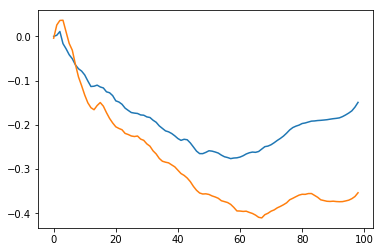

In [487]:
matplotlib.pyplot.plot(train_errors)
matplotlib.pyplot.plot(train_errors_val);

In [488]:
knn = KNeighborsRegressor(7)
knn.fit(X_train, y_train)
y_k_predict = knn.predict(X_train)

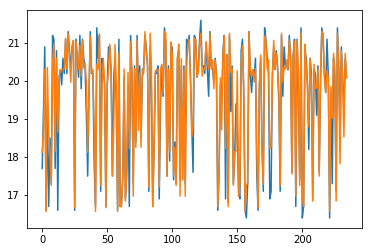

In [489]:
matplotlib.pyplot.plot(list(y_train))
matplotlib.pyplot.plot(y_k_predict.reshape(y_k_predict.shape[0]));

In [490]:
D_in = 15
D_out = 1
N = X_train.shape[0]

In [491]:
# Zufällige initialisierung der Gewichte
w = np.random.randn(D_in, D_out)
w

array([[ 0.93024199],
       [-1.27694146],
       [ 0.54165008],
       [ 1.2155067 ],
       [ 0.57561919],
       [ 0.45410613],
       [ 1.31019518],
       [ 0.74333844],
       [ 0.47260572],
       [ 0.09629344],
       [ 0.60827298],
       [-0.17151184],
       [ 0.86441043],
       [ 1.27844479],
       [-4.27632481]])

In [492]:
learning_rate = 1e-3

In [493]:
loss_hist = []
loss_hist_val = []
# Train
for t in range(100):
    # Berechne die Vorhersage
    y_pred = X_train.dot(w)
    y_pred_val = X_val.dot(w)
    y_pred = y_pred.reshape(y_pred.shape[0])
    y_pred_val = y_pred_val.reshape(y_pred_val.shape[0])
    # Berechne den Fehler (Ausgabe des Fehlers alle 100 Iterationen)
    loss = np.square(y_pred - y_train).sum()
    loss_val = np.square(y_pred_val - y_val).sum()
    if t % 1 == 0:
        loss_hist.append(loss)
        loss_hist_val.append(loss_val)
        print(t, loss)

    # Berechne die Gradienten von w1 im Bezug auf den Fehler 
    grad_y_pred = 2.0 * (y_pred - y_train)
    grad_w = (1/N) * X_train.T.dot(grad_y_pred)

    # Aktualisiere die Gewichte mittels Gradienten Abstieg
    w -= learning_rate * grad_w.sum()

0 81571.97929482785
1 67995.34140762882
2 56776.837576703765
3 47506.882139272195
4 39847.03060228865
5 33517.623091686226
6 28287.57401803974
7 23965.93518108216
8 20394.924283458124
9 17444.16432594
10 15005.923565407586
11 12991.182247268645
12 11326.382509391293
13 9950.742797094797
14 8814.03873894785
15 7874.769463527817
16 7098.642409678567
17 6457.321310947495
18 5927.3916433269715
19 5489.50576497361
20 5127.676537102187
21 4828.693636273438
22 4581.641247736887
23 4377.499530894769
24 4208.815306459191
25 4069.4299421466135
26 3954.2545020628872
27 3859.0839505211075
28 3780.4436269053936
29 3715.462386404024
30 3661.767775001725
31 3617.3994115879323
32 3580.7374147765713
33 3550.443261312743
34 3525.4109168168334
35 3504.726454657819
36 3487.634688647745
37 3473.511601322709
38 3461.841561171622
39 3452.198497017611
40 3444.230342231982
41 3437.6461808416097
42 3432.205626236337
43 3427.710044694815
44 3423.9953033011934
45 3420.925777480331
46 3418.3893993676816
47 3416.29

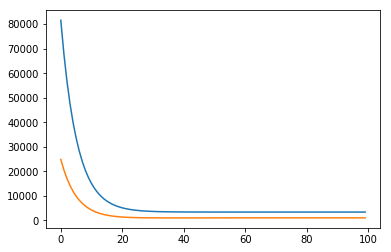

In [494]:
matplotlib.pyplot.plot(loss_hist)
matplotlib.pyplot.plot(loss_hist_val);

In [497]:
len(list(y_pred.reshape(y_pred.shape[0])))

235

In [498]:
sklearn.metrics.mean_squared_error(list(y_train), list(y_pred.reshape(y_pred.shape[0])))

14.494993248882778

In [499]:
len(list(y_train))

235

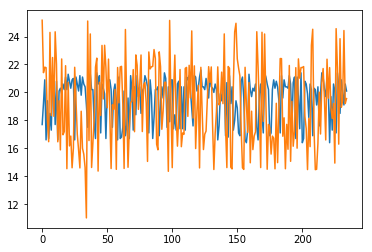

In [500]:
matplotlib.pyplot.plot(list(y_train))
matplotlib.pyplot.plot(list(y_pred));

In [501]:
#error = 
error = list(np.array(list(y_train)) - np.array(list(y_pred.reshape(y_pred.shape[0]))))

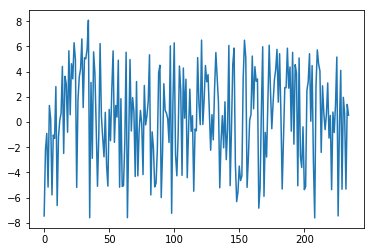

In [502]:
matplotlib.pyplot.plot(error);

In [503]:
w

array([[ 3.63404107],
       [ 1.42685762],
       [ 3.24544916],
       [ 3.91930578],
       [ 3.27941826],
       [ 3.1579052 ],
       [ 4.01399426],
       [ 3.44713752],
       [ 3.1764048 ],
       [ 2.80009251],
       [ 3.31207206],
       [ 2.53228723],
       [ 3.56820951],
       [ 3.98224386],
       [-1.57252574]])

In [ ]:
from IPython.core.display import display, HTML
display(HTML("

"))